In [1]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 1. Data load and split

In [2]:
def black_scholes_call_option(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    Returns:
        The Black-Scholes price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - 
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price


In [3]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
df.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,price,duration,remaining,T,midPrice
0,MMM250530C00100000,2025-05-22 17:35:58,100.0,50.25,46.65,50.6,0.0,0.0,10.0,0.0,3.499025,True,REGULAR,USD,2025-05-30,148.66,7,1,0.00274,48.625
1,MMM250530C00115000,2025-04-24 14:20:00,115.0,22.53,31.05,34.7,0.0,0.0,NaN,0.0,2.111333,True,REGULAR,USD,2025-05-30,148.66,35,1,0.00274,32.875
2,MMM250530C00119000,2025-04-30 14:57:01,119.0,18.12,27.70,31.6,0.0,0.0,2.0,0.0,2.269536,True,REGULAR,USD,2025-05-30,148.66,29,1,0.00274,29.650
3,MMM250530C00120000,2025-04-24 14:20:00,120.0,17.88,26.05,29.7,0.0,0.0,NaN,0.0,1.836915,True,REGULAR,USD,2025-05-30,148.66,35,1,0.00274,27.875
4,MMM250530C00123000,2025-05-23 15:34:16,123.0,25.50,24.70,26.9,0.0,0.0,32.0,32.0,1.087895,True,REGULAR,USD,2025-05-30,148.66,6,1,0.00274,25.800


In [4]:
df = pd.read_csv('../data/processed/calls_2025_05_28.csv')
df_final = df[['price', 'strike', 'T', 'impliedVolatility', 'midPrice']].copy()

# Rename columns for clarity
df_final.rename(columns={
    'price': 'S',  # Current stock price
    'strike': 'K',  # Strike price
    'T': 'T',  # Time to expiration in years
    'impliedVolatility': 'sigma',  # Volatility of the underlying stock
    'midPrice': 'call_price'  # Black-Scholes price of the call option
}, inplace=True)

In [5]:
INPUTS = df_final.columns.drop('call_price').tolist()
TARGET = 'call_price'

X = df_final[INPUTS]
y = df_final[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

### 2. MLP

#### A. Train model

In [8]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS)
        ])

param = {'MLP__alpha': [0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes': [
                (80,),          # 1 capa con 50 neuronas
                (40, 40),      # 2 capas: 40 → 40
                (80, 40, 20),   # 3 capas: 80 → 40 → 20
                (64, 64),       # 2 capas: 64 → 64
        ],
         'MLP__learning_rate_init': [0.01],
         'MLP__activation': ['tanh', 'relu'], # Activation function
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', 
                max_iter=2000, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS], y_train) # Search in grid


# Save the model
import joblib
joblib.dump(MLP_fit, '../models/MLP_simple_vs_BS_v3(multilayer).pkl')

Iteration 1, loss = 10821.09767033
Iteration 2, loss = 7379.35887514
Iteration 1, loss = 10712.79136240
Iteration 3, loss = 5858.73155805
Iteration 1, loss = 10947.32681390
Iteration 1, loss = 10696.25972430
Iteration 1, loss = 10951.76825705
Iteration 4, loss = 4964.04528498
Iteration 2, loss = 7260.02539295
Iteration 1, loss = 10814.52677598
Iteration 1, loss = 11011.76360589
Iteration 1, loss = 11013.78931322
Iteration 2, loss = 7423.74211691
Iteration 2, loss = 7282.09017908
Iteration 2, loss = 7399.26222006
Iteration 5, loss = 4313.22299040
Iteration 3, loss = 5775.33924686
Iteration 2, loss = 7358.57526839
Iteration 2, loss = 7484.53500326
Iteration 2, loss = 7517.39442856
Iteration 3, loss = 5768.41198453
Iteration 3, loss = 5888.06570717
Iteration 3, loss = 5836.13074712
Iteration 6, loss = 3845.87774126
Iteration 4, loss = 4886.60264742
Iteration 3, loss = 5833.36391719
Iteration 3, loss = 5922.86125684
Iteration 3, loss = 5957.61353519
Iteration 4, loss = 4971.85335412
Iterat

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


['../models/MLP_simple_vs_BS_v3(multilayer).pkl']

#### B. Load Model

In [8]:
import joblib

# Cargamos el modelo guardado
MLP_fit = joblib.load('../models/MLP_simple_vs_BS_v2.pkl')

### 3. MLP vs Black-Scholes

#### A. Graphic

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plotModelGridError(MLP_fit):
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']
    params = results['params']

    # Convertir a error (RMSE)
    errors = np.sqrt(-mean_test_scores)

    # Etiquetas incluyendo todos los hiperparámetros relevantes
    param_labels = [
        f"act: {p['MLP__activation']}, alpha: {p['MLP__alpha']}, size: {p['MLP__hidden_layer_sizes']}, lr: {p['MLP__learning_rate_init']}"
        for p in params
    ]

    # Obtener todos los learning rates únicos para codificarlos por color
    lrs = [p['MLP__learning_rate_init'] for p in params]
    unique_lrs = sorted(set(lrs))
    lr_color_map = {lr: cm.viridis(i / len(unique_lrs)) for i, lr in enumerate(unique_lrs)}
    bar_colors = [lr_color_map[lr] for lr in lrs]

    # Ordenar por error creciente
    sorted_indices = np.argsort(errors)
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    bar_colors_sorted = [bar_colors[i] for i in sorted_indices]

    # Crear el gráfico
    plt.figure(figsize=(14, 10))
    bars = plt.barh(param_labels_sorted, errors_sorted, color=bar_colors_sorted)
    plt.xlabel("RMSE")
    plt.title("Errores del Modelo (RMSE) según Grid Search, agrupados por Learning Rate")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Crear leyenda manual
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=lr_color_map[lr]) for lr in unique_lrs
    ]
    legend_labels = [f"lr: {lr}" for lr in unique_lrs]
    plt.legend(legend_handles, legend_labels, title="Learning Rate", loc="lower right")

    plt.show()

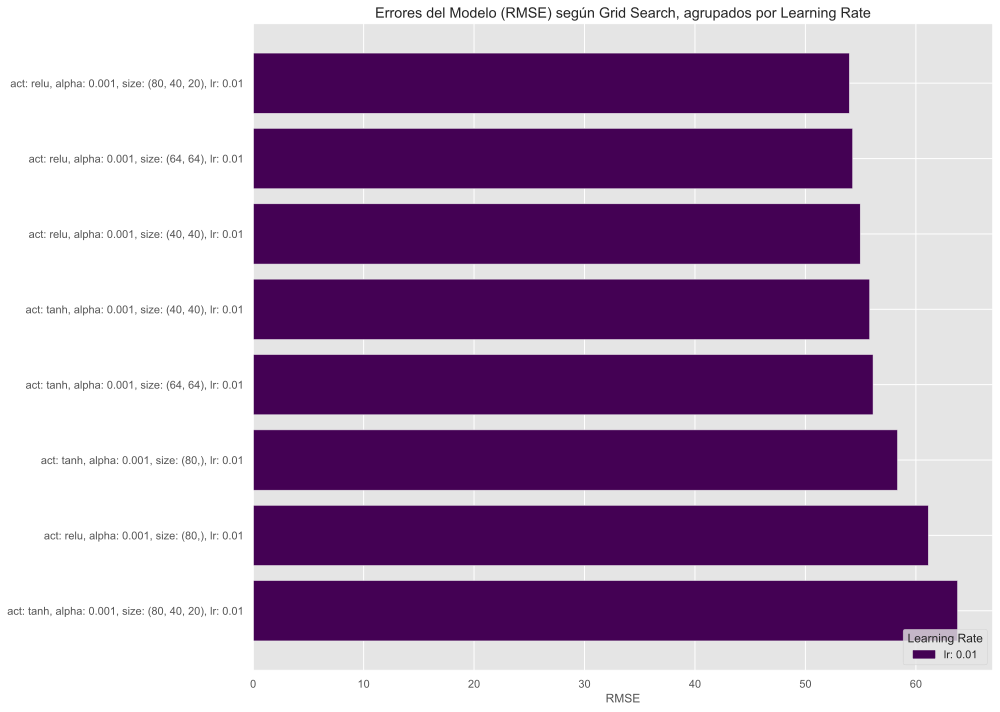

In [10]:
plotModelGridError(MLP_fit)
# La mejor combinación es ReLu, alpha=0.001, size=(60,), lr=0.1

#### B. Comparison of metrics

In [10]:
# Calculate the predictions on the training set using Black-Scholes formula
dfTR_eval['BS_predict'] = black_scholes_call_option(
    dfTR_eval['S'],
    dfTR_eval['K'],
    dfTR_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTR_eval['sigma']
)

# Calculate the predictions on the test set using Black-Scholes formula
dfTS_eval['BS_predict'] = black_scholes_call_option(
    dfTS_eval['S'],
    dfTS_eval['K'],
    dfTS_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTS_eval['sigma']
)


In [11]:
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train[INPUTS])
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test[INPUTS])

In [12]:
#Training and test MAE - Mean Absolute error
print('MLP Predictions')
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

MLP Predictions
Training MAE: 9.67836502473077
Test MAE: 9.705840593850981
Training RMSE: 48.948860299965524
Test RMSE: 48.415710216896954
Training R2: 0.8942082431770965
Test R2: 0.8952444876702017


In [13]:
print('Black-Scholes Predictions')
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))

Black-Scholes Predictions
Training MAE: 9.841660704462235
Test MAE: 9.663280553763935
Training RMSE: 78.56478258549213
Test RMSE: 75.49717139474701
Training R2: 0.7274648728761347
Test R2: 0.7452784831439758


#### C. Case to case comparison

In [14]:
import numpy as np
dfTS_eval['MLP_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['MLP_pred'])
dfTS_eval['BS_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['BS_predict'])
dfTS_eval['MLP_better'] = dfTS_eval['MLP_diff'] < dfTS_eval['BS_diff']

# Casos en los que MLP es mejor
mlp_better_cases = dfTS_eval[dfTS_eval['MLP_better']]
bs_better_cases = dfTS_eval[~dfTS_eval['MLP_better']]

# Diferencias de error entre ambos modelos
mlp_margin = bs_better_cases['BS_diff'] - bs_better_cases['MLP_diff']
bs_margin = mlp_better_cases['MLP_diff'] - mlp_better_cases['BS_diff']

# Estadísticas descriptivas
print("Cuando BS gana:")
print("   Media de mejora:", mlp_margin.mean())
print("   Mediana de mejora:", mlp_margin.median())

print("Cuando MLP gana:")
print("   Media de mejora:", bs_margin.mean())
print("   Mediana de mejora:", bs_margin.median())

Cuando BS gana:
   Media de mejora: -6.589019647663009
   Mediana de mejora: -2.7606293219889153
Cuando MLP gana:
   Media de mejora: -13.873884408310142
   Mediana de mejora: -1.9688810655727593


In [ ]:
from utils import plotModelDiagnosis
plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'midPrice')

### 4. Neuralsense

In [15]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS)


In [16]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [17]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [18]:
sensmlp.summary()

Sensitivity analysis of [4, 80, 1] MLP network.

Sensitivity measures of each output:

$call_price 

                  mean         std  mean_squared
num__S      325.231808  131.236117    350.711630
num__K     -247.788071  123.050840    276.659425
num__T       35.346249   69.582102     78.045027
num__sigma   50.413621   88.707129    102.031799


In [19]:
sensmlp.info()

Sensitivity analysis of [4, 80, 1] MLP network.

115689 samples

Sensitivities of each output (only 5 first samples):

$call_price 

       num__S      num__K     num__T  num__sigma
0  337.378266 -309.331245   2.553185   -4.095909
1  531.032697 -527.696297   3.638315  214.772553
2   49.159725   -3.218166  30.500774    7.708914
3  453.397031 -448.344609   4.679930  156.422229
4  575.404064 -298.075704   7.227773  -46.582057


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


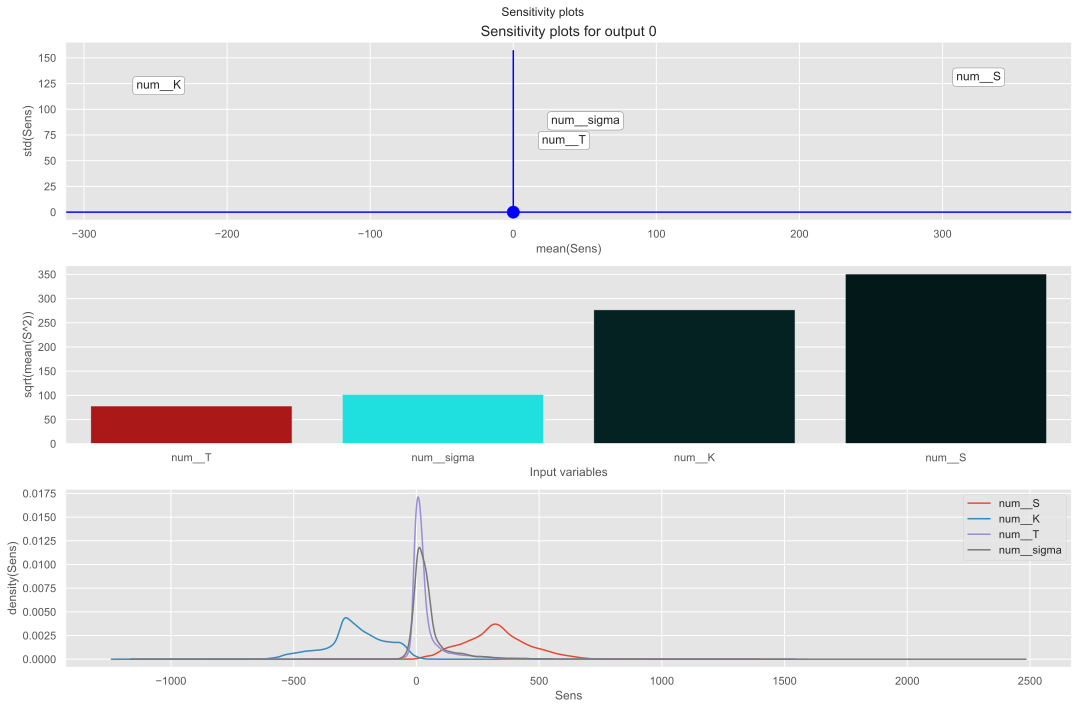

In [20]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

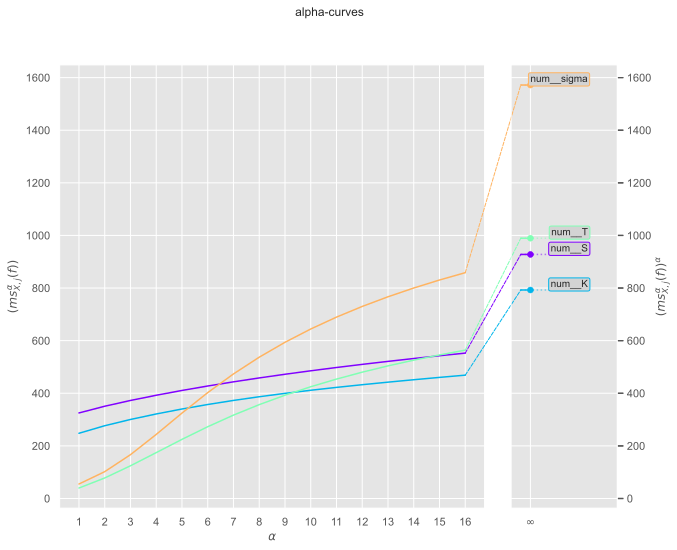

In [21]:
ns.alpha_sens_curves(sensmlp)

In [22]:
df_partDeriv = sensmlp.raw_sens[0]

In [23]:
df_partDeriv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115689 entries, 0 to 115688
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num__S      115689 non-null  float64
 1   num__K      115689 non-null  float64
 2   num__T      115689 non-null  float64
 3   num__sigma  115689 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial
    contenida en un DataFrame, útil para detectar outliers o anomalías.

    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S, num__K, etc.
    """
    plt.figure(figsize=(14, 9))
    for i, column in enumerate(df.columns, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[column], kde=True, bins=100)
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Media: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Mediana: {df[column].median():.2f}")
        plt.title(f"Distribución de ∂Precio/∂{column.split('__')[-1]}")
        plt.xlabel("Valor de la derivada parcial")
        plt.ylabel("Frecuencia")
        plt.legend()
    plt.tight_layout()
    plt.show()

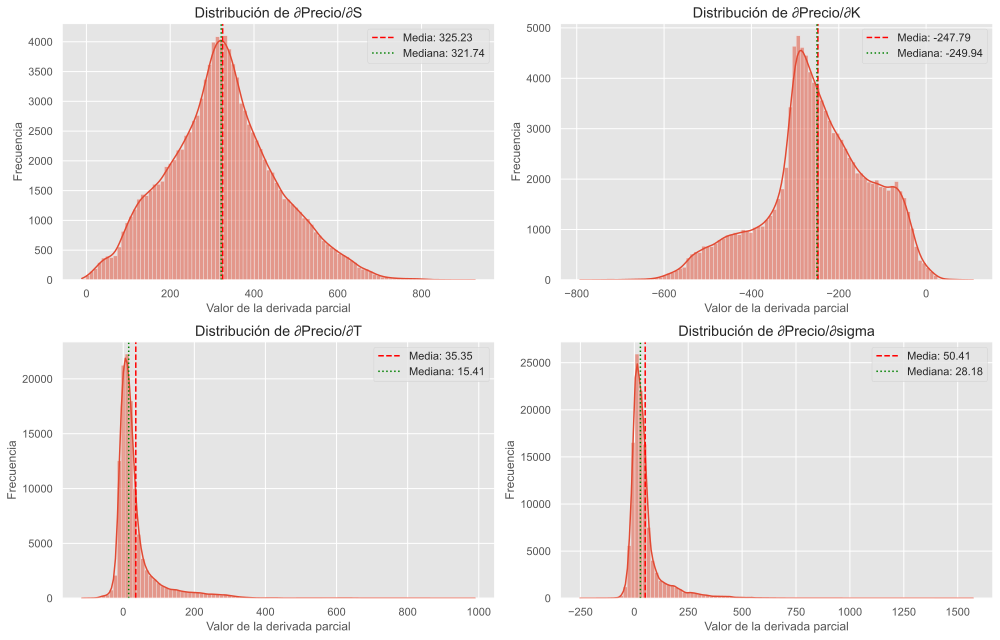

In [39]:
plot_partial_derivative_distributions(df_partDeriv)

In [26]:
def get_outliers_std(df, column, n_std=3):
    media = df[column].mean()
    std = df[column].std()
    return df[np.abs(df[column] - media) > n_std * std]

In [60]:
outliers_sigma = get_outliers_std(df_partDeriv, 'num__sigma', n_std=12)

## get a subdataframe with the outliers using the positional index in outlier_indices
outlier_rows = dfTR_eval.iloc[outliers_sigma.index]
# Display the outlier rows
outlier_rows.head(50)


outliers_sigma.sort_values(by='num__sigma', ascending=False).head(50)

,num__S,num__K,num__T,num__sigma
22569,584.606151,-558.999913,213.891510,1571.733976
99271,354.500714,-365.168632,198.284296,1519.076429
97215,334.881029,-350.158951,200.354775,1500.111570
77785,333.146169,-353.613409,175.466468,1471.993577
37282,699.361365,-695.438770,393.913540,1444.855488
86573,406.164540,-420.064957,354.387210,1435.130895
81693,410.481838,-439.872037,356.984797,1434.481498
43593,409.492176,-431.457653,356.518294,1425.299958
30743,468.513344,-446.692182,381.023691,1420.788236
57193,395.690235,-400.901222,341.457112,1420.216516


In [36]:
outliers_T = get_outliers_std(df_partDeriv, 'num__T', n_std=3)
outlier_rows_T = dfTR_eval.iloc[outliers_T.index]
# Display the outlier rows for T
outlier_rows_T.head(10)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
1608,412.23,367.5,0.002740,1.290043,44.475,45.252410,63.274039
88692,57.46,27.0,0.002740,4.976566,30.800,30.468848,21.839552
79617,140.22,45.0,0.060274,2.735355,96.400,96.283884,94.561327
108521,23.18,18.0,0.002740,2.031255,5.325,5.188486,-2.397472
54413,1619.94,2900.0,0.136986,0.670902,2.000,1.839285,-8.789537
21908,5475.26,5050.0,0.309589,0.374503,671.050,725.274694,667.310561
22001,5475.26,4860.0,0.386301,0.393458,856.750,923.651096,862.809864
7112,173.38,110.0,0.002740,2.167973,63.475,63.393667,54.126889
88703,57.46,45.0,0.002740,1.792970,12.700,12.472399,11.564038
79905,469.98,522.5,0.002740,0.937989,2.150,0.134918,35.192955


In [37]:
outliers_K = get_outliers_std(df_partDeriv, 'num__K', n_std=3)
outlier_rows_K = dfTR_eval.iloc[outliers_K.index]
outlier_rows_K.head(10)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
95499,1208.550,220.0,0.558904,0.000010,463.775,994.014149,760.335055
22079,5475.260,3220.0,0.558904,0.583351,2354.650,2420.646073,2156.485336
95141,1208.550,720.0,0.213699,0.737033,497.875,503.648013,499.728534
95501,1208.550,240.0,0.558904,0.000010,703.275,974.510890,736.849971
38957,1013.140,580.0,0.213699,0.727054,438.625,443.465796,434.397539
126301,356.900,165.0,0.002740,2.843753,191.925,191.920342,190.086268
81209,315.745,125.0,0.213699,1.198734,192.975,193.938449,190.619642
95691,1208.550,270.0,0.635616,0.000010,348.000,946.163339,704.608266
87751,643.580,140.0,1.632877,0.568120,504.950,514.465031,528.665841
95683,1208.550,195.0,0.635616,0.000010,411.000,1019.048523,792.643399


In [30]:
outlier_rows[outlier_rows['sigma']== 0].head(50)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
